# Install

In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163008 sha256=02640bc9c472d2d4ed1b94229c473d46700326a59d04d2404f1581e64eeb7876
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


# Import

In [2]:
import pandas as pd
import zipfile
import os
import urllib.request

from re import search

from surprise import SVD, Dataset, Reader, NormalPredictor, SVDpp, NMF, KNNBasic, accuracy
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV, KFold

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# unzip + merge

In [3]:
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
zip_file_path = 'ml-latest-small.zip'
urllib.request.urlretrieve(url, zip_file_path)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

folder_path = 'ml-latest-small'

In [4]:
ratings = pd.read_csv(os.path.join(folder_path, 'ratings.csv'))
# tags = pd.read_csv(os.path.join(folder_path, 'tags.csv'))
movies = pd.read_csv(os.path.join(folder_path, 'movies.csv'))
# links = pd.read_csv(os.path.join(folder_path, 'links.csv'))

merged_df = ratings.merge(movies, on='movieId', how='outer')

# merged_df.to_csv('merged_dataset.csv', index=False)

In [5]:
merged_df.drop('timestamp', axis=1, inplace=True)

In [6]:
merged_df.head()

,userId,movieId,rating,title,genres
0,1.0,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5.0,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7.0,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15.0,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17.0,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [7]:
merged_df.shape[0]

100854

In [8]:
merged_df.shape[1]

5

In [9]:

num_users = merged_df['userId'].nunique()
num_items = merged_df['movieId'].nunique()
num_ratings = len(ratings)

print("Кількість користувачів:", num_users)
print("Кількість елементів:", num_items)
print("Кількість оцінок:", num_ratings)

Кількість користувачів: 610
Кількість елементів: 9742
Кількість оцінок: 100836


# Dataset ml-100k

In [10]:
data = Dataset.load_builtin('ml-100k')


Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [11]:
trainset = data.build_full_trainset()

print("Кількість користувачів:", trainset.n_users)
print("Кількість елементів:", trainset.n_items)
print("Кількість оцінок:", trainset.n_ratings)

Кількість користувачів: 943
Кількість елементів: 1682
Кількість оцінок: 100000


In [12]:
raw_data = data.raw_ratings
# Конвертуємо
# df = pd.DataFrame(raw_data, columns=['user_id', 'item_id', 'rating', 'timestamp'])
df = pd.DataFrame(raw_data)
df.head()

,0,1,2,3
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


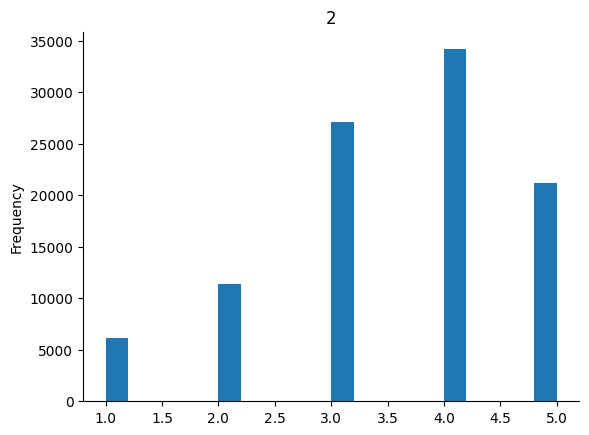

In [13]:
# @title 2

from matplotlib import pyplot as plt
df[2].plot(kind='hist', bins=20, title=2)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
kf = KFold(n_splits=2)
algo = SVD()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.9545
RMSE: 0.9604


# Algorithm

In [15]:
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9337  0.9433  0.9233  0.9338  0.9443  0.9357  0.0077  
MAE (testset)     0.7350  0.7421  0.7287  0.7353  0.7459  0.7374  0.0060  
Fit time          1.32    1.35    2.01    1.33    1.35    1.47    0.27    
Test time         0.13    0.28    0.15    0.11    0.12    0.16    0.06    


{'test_rmse': array([0.93368856, 0.9432771 , 0.92326225, 0.93375451, 0.9443306 ]),
 'test_mae': array([0.73499283, 0.74213029, 0.72872026, 0.73531814, 0.74587662]),
 'fit_time': (1.3228821754455566,
  1.3514952659606934,
  2.0123496055603027,
  1.3331849575042725,
  1.3541436195373535),
 'test_time': (0.13057494163513184,
  0.281235933303833,
  0.14593172073364258,
  0.11425495147705078,
  0.12181997299194336)}

In [16]:
reader = Reader(rating_scale=(1, 5))
data2 = Dataset.load_from_df(merged_df[['userId', 'movieId', 'rating']], reader)

algo = NormalPredictor()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data2, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    nan     nan     nan     nan     nan     nan     nan     
MAE (testset)     nan     nan     nan     nan     nan     nan     nan     
Fit time          0.11    0.15    0.14    0.14    0.14    0.14    0.01    
Test time         0.08    0.08    0.23    0.07    0.09    0.11    0.06    


{'test_rmse': array([nan, nan, nan, nan, nan]),
 'test_mae': array([nan, nan, nan, nan, nan]),
 'fit_time': (0.11412405967712402,
  0.14868736267089844,
  0.14146637916564941,
  0.14421582221984863,
  0.1392054557800293),
 'test_time': (0.08176374435424805,
  0.08198165893554688,
  0.22602629661560059,
  0.07452750205993652,
  0.08931350708007812)}

In [17]:
unique_ratings = merged_df['rating'].unique()
print(unique_ratings)


[4.  4.5 2.5 3.5 3.  5.  0.5 2.  1.5 1.  nan]


In [18]:
nan_rows = merged_df[merged_df.isna().any(axis=1)]
nan_rows.head()

,userId,movieId,rating,title,genres
100836,NaN,1076,NaN,"Innocents, The (1961)",Drama|Horror|Thriller
100837,NaN,2939,NaN,Niagara (1953),Drama|Thriller
100838,NaN,3338,NaN,For All Mankind (1989),Documentary
100839,NaN,3456,NaN,"Color of Paradise, The (Rang-e khoda) (1999)",Drama
100840,NaN,4194,NaN,I Know Where I'm Going! (1945),Drama|Romance|War


In [19]:
merged_df.dropna(subset=['rating'], inplace=True)

In [20]:
nan_rows = merged_df[merged_df.isna().any(axis=1)]
nan_rows.head()

,userId,movieId,rating,title,genres


Повторюємо розрахунок після заміни NaN

In [21]:
reader = Reader(rating_scale=(1, 5))
data2 = Dataset.load_from_df(merged_df[['userId', 'movieId', 'rating']], reader)

algo = NormalPredictor()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data2, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4152  1.4262  1.4295  1.4294  1.4092  1.4219  0.0082  
MAE (testset)     1.1320  1.1364  1.1434  1.1385  1.1284  1.1357  0.0052  
Fit time          0.11    0.14    0.16    0.14    0.16    0.14    0.02    
Test time         0.08    0.08    0.24    0.08    0.08    0.11    0.06    


{'test_rmse': array([1.41516678, 1.42620999, 1.42950135, 1.42939147, 1.40920078]),
 'test_mae': array([1.13198455, 1.13639164, 1.14335638, 1.13854657, 1.12837118]),
 'fit_time': (0.1145012378692627,
  0.14395689964294434,
  0.16123199462890625,
  0.14281225204467773,
  0.16023540496826172),
 'test_time': (0.07738566398620605,
  0.07708573341369629,
  0.23559832572937012,
  0.08253765106201172,
  0.08248400688171387)}

**модель матричної факторизації**

In [22]:
algo = SVD()

cv_results = cross_validate(algo, data2, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8744  0.8718  0.8750  0.8723  0.8717  0.8730  0.0014  
MAE (testset)     0.6718  0.6709  0.6687  0.6711  0.6717  0.6708  0.0011  
Fit time          1.54    2.07    1.53    1.51    1.52    1.63    0.22    
Test time         0.21    0.11    0.26    0.11    0.11    0.16    0.06    


For date2 we get an average root mean square error of 0.87, which is good enough for our case.

# SVD

In [23]:
param_grid = {'n_factors': [10, 20],
              'n_epochs': [10, 20],
              'lr_all': [0.01, 0.05],
              'reg_all': [0.1, 0.2]}

# Ініціалізуємо об'єкт GridSearchCV
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs.fit(data)

In [24]:
print(gs.best_params['rmse'])
print('')
print(gs.best_score['rmse'])

{'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.05, 'reg_all': 0.1}

0.9265930066089048


In [25]:
param_grid = {'n_factors': [10, 20],
              'n_epochs': [10, 20],
              'lr_all': [0.01, 0.05],
              'reg_all': [0.1, 0.2]}

# Ініціалізуємо об'єкт GridSearchCV
gs_merge = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs_merge.fit(data2)

In [26]:
print(gs_merge.best_params['rmse'])
print('')
print(gs_merge.best_score['rmse'])

{'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.05, 'reg_all': 0.1}

0.8648223281201896


# SVDpp

In [31]:
param_grid = {"cache_ratings": [True],
              'n_factors': [10, 20],
              'n_epochs': [10, 20],
              'lr_all': [0.01, 0.05],
              'reg_all': [0.1, 0.2]}

gs_SVDpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs_SVDpp.fit(data)

In [32]:
print(gs_SVDpp.best_params['rmse'])
print('')
print(gs_SVDpp.best_score['rmse'])

{'cache_ratings': True, 'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}

0.9207177714610901


In [33]:
param_grid = {"cache_ratings": [True],
              'n_factors': [10, 20],
              'n_epochs': [10, 20],
              'lr_all': [0.01, 0.05],
              'reg_all': [0.1, 0.2]}

gs_SVDpp_merge = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs_SVDpp_merge.fit(data2)

In [34]:
print(gs_SVDpp_merge.best_params['rmse'])
print('')
print(gs_SVDpp_merge.best_score['rmse'])

{'cache_ratings': True, 'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}

0.8605539713402418


# NMF

In [27]:
param_grid = {'n_factors': [10, 20],
              'n_epochs': [15, 20],
              'reg_pu': [0.05, 0.1],  # регуляризація користувачів
              'reg_qi': [0.05, 0.1]}  # регуляризація об'єктів

gs_NMF = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs_NMF.fit(data)

In [28]:
print(gs_NMF.best_params['rmse'])
print('')
print(gs_NMF.best_score['rmse'])

{'n_factors': 10, 'n_epochs': 15, 'reg_pu': 0.1, 'reg_qi': 0.1}

0.98312780121736


In [29]:
param_grid = {'n_factors': [10, 20],
              'n_epochs': [15, 20],
              'reg_pu': [0.05, 0.1],  # регуляризація користувачів
              'reg_qi': [0.05, 0.1]}  # регуляризація об'єктів

gs_NMF_merge = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
gs_NMF_merge.fit(data2)

In [30]:
print(gs_NMF_merge.best_params['rmse'])
print('')
print(gs_NMF_merge.best_score['rmse'])

{'n_factors': 10, 'n_epochs': 15, 'reg_pu': 0.1, 'reg_qi': 0.1}

0.9299620509586395


# **Summary**

In [35]:
pd.set_option('display.max_colwidth', None)

data_svd = {
    'Algorithm': ['SVD', 'SVD Merge'],
    'Best Params (RMSE)': [gs.best_params['rmse'], gs_merge.best_params['rmse']],
    'Best RMSE Score': [gs.best_score['rmse'], gs_merge.best_score['rmse']]
}

svdpp_best_params = {
    'SVDpp': gs_SVDpp.best_params,
    'SVDpp Merge': gs_SVDpp_merge.best_params
}

svdpp_best_params['SVDpp Merge'] = svdpp_best_params['SVDpp Merge']['rmse']

data_svdpp = {
    'Algorithm': ['SVDpp', 'SVDpp Merge'],
    'Best Params (RMSE)': [svdpp_best_params['SVDpp']['rmse'], svdpp_best_params['SVDpp Merge']],
    'Best RMSE Score': [gs_SVDpp.best_score['rmse'], gs_SVDpp_merge.best_score['rmse']]
}

data_nmf = {
    'Algorithm': ['NMF', 'NMF Merge'],
    'Best Params (RMSE)': [gs_NMF.best_params['rmse'], gs_NMF_merge.best_params['rmse']],
    'Best RMSE Score': [gs_NMF.best_score['rmse'], gs_NMF_merge.best_score['rmse']]
}

df = pd.concat([pd.DataFrame(data_svd), pd.DataFrame(data_svdpp), pd.DataFrame(data_nmf)], ignore_index=True)
df


,Algorithm,Best Params (RMSE),Best RMSE Score
0,SVD,"{'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.05, 'reg_all': 0.1}",0.926593
1,SVD Merge,"{'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.05, 'reg_all': 0.1}",0.864822
2,SVDpp,"{'cache_ratings': True, 'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}",0.920718
3,SVDpp Merge,"{'cache_ratings': True, 'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}",0.860554
4,NMF,"{'n_factors': 10, 'n_epochs': 15, 'reg_pu': 0.1, 'reg_qi': 0.1}",0.983128
5,NMF Merge,"{'n_factors': 10, 'n_epochs': 15, 'reg_pu': 0.1, 'reg_qi': 0.1}",0.929962


NMF: Має найгірше значення RMSE серед усіх моделей. Це свідчить про те, що вона не вловлює всі складні взаємозв'язки між користувачами та предметами

SVDpp: Має найточніші показники при однакових наборах параметрів. SVDpp покращує результати звичайної SVD завдяки персоналізації за допомогою факторів користувачів.

# Розріджена матриця та рекомендація

## Підготовка

In [36]:
ratings = pd.read_csv(os.path.join(folder_path, 'ratings.csv'))
movies = pd.read_csv(os.path.join(folder_path, 'movies.csv'))

In [37]:
ratings.drop('timestamp', axis=1, inplace=True)
ratings.head(3)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0


In [38]:
movies.drop('genres', axis=1, inplace=True)
movies.head(3)

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)


## Створюємо матрицю

горизонталь - фільми, вертикаль - користувачі, значення - оцінки

In [39]:
user_items_matrix = ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating')
user_items_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
user_items_matrix.fillna(0,inplace=True)
user_items_matrix.head()
display(user_items_matrix.shape)

(9724, 610)

In [41]:
user_items_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


прибираємо неактивних користувачі та фільми з невеликою кількістю оцінок

In [42]:
user_votes = ratings.groupby ('userId')['rating'].agg('count')
user_mask = user_votes[user_votes > 50].index
user_items_matrix = user_items_matrix.loc[:, user_mask]

movie_votes = ratings.groupby ('movieId')['rating'].agg('count')
movie_mask = movie_votes[movie_votes > 10].index
user_items_matrix = user_items_matrix.loc[movie_mask, :]

user_items_matrix.shape

(2121, 378)

In [43]:
user_items_matrix

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Перетворюємо розріджену матрицю на стисле зберігання за допомогою функції csr_matrix бібліотеки scipy.sparse

In [44]:
csr_data = csr_matrix(user_items_matrix.values)
print(csr_data[:2,:5])

  (0, 0)	4.0
  (0, 3)	4.5
  (1, 2)	4.0


In [45]:
user_items_matrix = user_items_matrix.rename_axis(None, axis = 1).reset_index()
user_items_matrix.head()

,movieId,1,4,6,7,10,11,15,16,17,...,600,601,602,603,604,605,606,607,608,610
0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


## Навчання

In [46]:
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors= 20, n_jobs = -1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

## Рекомендації (Прогнозування)

Початкові параметри пошуку

In [47]:
recomendations = 10
search_word = 'Matrix'

Пошук індексу фільму у матриці переваг

In [48]:
movie_search = movies[movies['title'].str.contains(search_word)]
movie_search

,movieId,title
1939,2571,"Matrix, The (1999)"
4351,6365,"Matrix Reloaded, The (2003)"
4639,6934,"Matrix Revolutions, The (2003)"


In [49]:
# варіантів кілька. через iloc[0] беремо перший рядок стовпця
movie_id = movie_search.iloc[0]['movieId']

# далі за індексом фільму у датасеті знайдемо індекс у матриці переваг
movie_id = user_items_matrix[user_items_matrix['movieId']==movie_id].index[0]
movie_id

901

знаходимо схожі фільми

In [50]:
# знаходимо індекси та фідстані фільмів, які схожі на запит
distances, indices = knn.kneighbors(csr_data[movie_id], n_neighbors=recomendations + 1)

In [51]:
# індекси рекомендованих фільмів
indices

array([[ 901, 1002,  442,  454,  124,  735,  954, 1362, 1157, 1536,  978]])

In [52]:
# відстані до них
distances

array([[0.        , 0.22982441, 0.25401128, 0.27565617, 0.27760886,
        0.28691008, 0.29111012, 0.31393358, 0.31405926, 0.31548004,
        0.31748544]])

In [53]:
# приберемо зайві виміри через squeeze() і перетворимо масиви у списки за допомогою tolist()
indices_list = indices.squeeze().tolist()
distances_list = distances.squeeze().tolist()

# далі перетворюємо списки
indices_distances = list(zip(indices_list, distances_list))
print(indices_distances[:3])

[(901, 0.0), (1002, 0.22982440568634488), (442, 0.25401128310081567)]


In [54]:
# сортуємо список на відстані за другим елементом у зростаючому порядку
indices_distances_sorted = sorted(indices_distances, key = lambda x: x[1], reverse = False)

# і прибрати перший елемент, оскільки це і є початковий фільм за search_word
indices_distances_sorted = indices_distances_sorted[1:]
indices_distances_sorted

[(1002, 0.22982440568634488),
 (442, 0.25401128310081567),
 (454, 0.27565616686043737),
 (124, 0.2776088577731709),
 (735, 0.2869100842838125),
 (954, 0.2911101181714415),
 (1362, 0.31393358217709477),
 (1157, 0.31405925934381695),
 (1536, 0.3154800434449465),
 (978, 0.31748544046311844)]

Знаходимо назви фільмів, які відповідають знайденим індексам

In [55]:
recom_list =[]
for ind_dist in indices_distances_sorted:

  matrix_movie_id = user_items_matrix.iloc[ind_dist[0]]['movieId']
  id = movies[movies['movieId'] == matrix_movie_id].index #індекс фільму у датафреймі муві
  title = movies.iloc[id]['title'].values[0] #назва фільму та відстань до нього
  dist = ind_dist[1]
  recom_list.append({'Title': title, 'Distance': dist})

In [56]:
recom_list[0]

{'Title': 'Fight Club (1999)', 'Distance': 0.22982440568634488}

In [57]:
# перетворюємо список на датафрейм. Індекс починаємо з 1
recom_df = pd.DataFrame(recom_list, index = range(1, recomendations + 1))
recom_df

,Title,Distance
1,Fight Club (1999),0.229824
2,Star Wars: Episode V - The Empire Strikes Back (1980),0.254011
3,Star Wars: Episode VI - Return of the Jedi (1983),0.275656
4,Star Wars: Episode IV - A New Hope (1977),0.277609
5,Saving Private Ryan (1998),0.286910
6,"Sixth Sense, The (1999)",0.291110
7,"Lord of the Rings: The Fellowship of the Ring, The (2001)",0.313934
8,Gladiator (2000),0.314059
9,"Lord of the Rings: The Return of the King, The (2003)",0.315480
10,American Beauty (1999),0.317485
